In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [176]:
from sklearn.datasets import load_iris
import pandas as pd

df = pd.DataFrame(load_iris()['data'])
y = df.values
# Standardize the data
y = (y - y.mean(axis=0)) / y.std(axis=0)

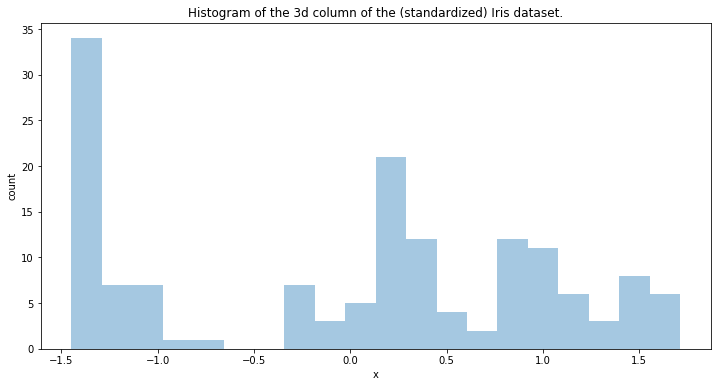

In [177]:
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.title('Histogram of the 3d column of the (standardized) Iris dataset.')
plt.xlabel('x')
plt.ylabel('count')
sns.distplot(y[:, 3], bins=20, kde=None)

In [182]:
import pymc3 as pm
from theano import tensor as tt

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

K = 30

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=y[:, 2])

In [183]:
with model: 
    step = None
    trace = pm.sample(500, tune=500, init='advi', random_seed=35171, step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 246.67:   5%|▍         | 9824/200000 [00:07<02:01, 1566.38it/s]
Convergence achieved at 9900
Interrupted at 9,899 [4%]: Average Loss = 256.03
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:38<00:00, 52.28draws/s]
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8817947919557028, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


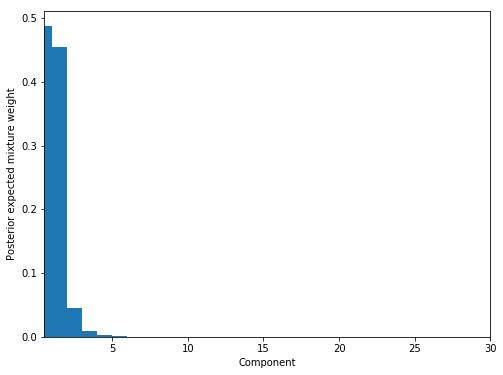

In [184]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [254]:
x_plot = np.linspace(-1.8, 1.8, 200)
# Calculate pdf for points in x_plot
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
# Weight (Gaussian) posterior probabilities by the posterior of w
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

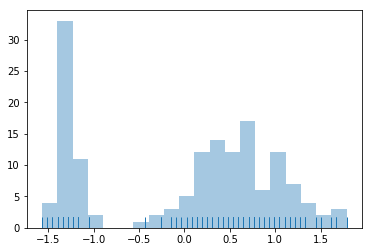

In [255]:
sns.distplot(y[:, 2], rug=True, label='Original dataset', kde=False, bins=20)

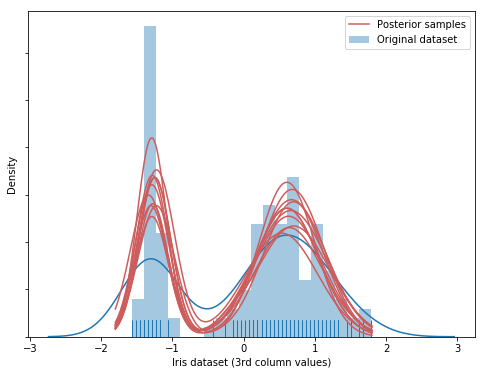

In [256]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(y[:, 2], rug=True, label='Original dataset', bins=20)

ax.plot(x_plot, post_pdfs[0],
        c='#CD5C5C', label='Posterior samples'); # Add this to plot the legend
ax.plot(x_plot, post_pdfs[::100].T, c='#CD5C5C');


ax.set_xlabel('Iris dataset (3rd column values)');
ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend();

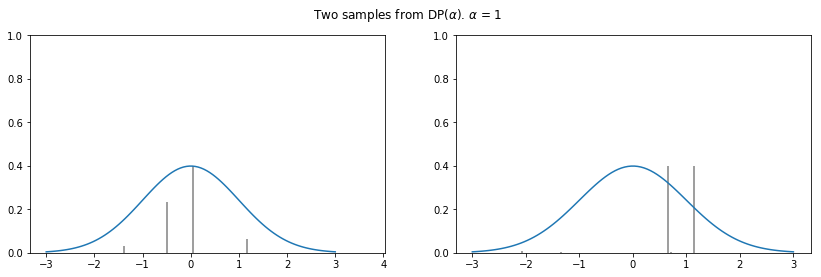

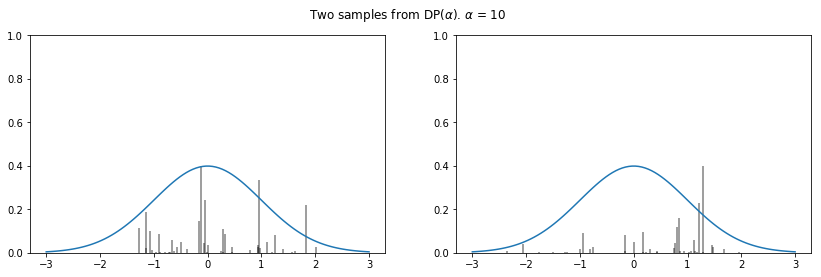

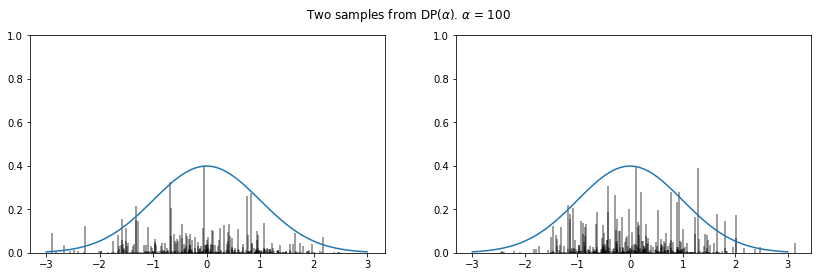

In [69]:
def DP(h, alpha):
    n = max(int(5 * alpha + 2), 500)
    pi = stats.beta(1, alpha).rvs(size=n) # sample weights
    pi[1:] = pi[1:] * (1 - pi[:-1]).cumprod() # stick-breaking
    theta = h(size=n) # random draws from h
    return pi, theta # return parameters of G
        
def plot_normal_dp_approximation(alpha, n=2):
    pi, theta = DP(stats.norm.rvs, alpha)
    x = np.linspace(-3, 3, 100)
    
    plt.figure(figsize=(14, 4))
    plt.suptitle(r'Two samples from DP($\alpha$). $\alpha$ = {}'.format(alpha))
    plt.ylabel(r'$\pi$')
    plt.xlabel(r'$\theta$')
    pltcount = int('1' + str(n) + '0')
    
    for i in range(n):
        pltcount += 1
        plt.subplot(pltcount)
        pi, theta = dirichlet_process(stats.norm.rvs, alpha)
        pi = pi * (stats.norm.pdf(0) / pi.max())
        plt.vlines(theta, 0, pi, alpha=0.5)
        plt.ylim(0, 1)
        plt.plot(x, stats.norm.pdf(x))

np.random.seed(3)
for alpha in [1, 10, 100]:
    plot_normal_dp_approximation(alpha)

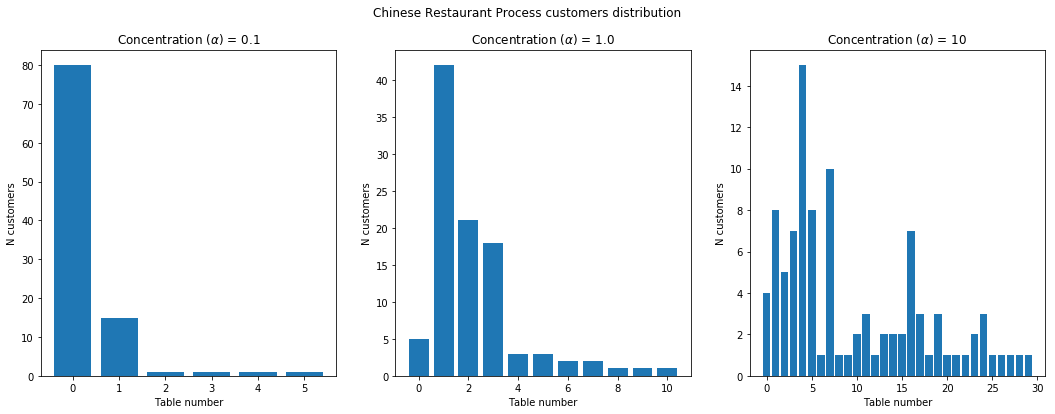

In [171]:
import random
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 6

fig, axs = plt.subplots(1, 3)
plot_count = 0
fig.suptitle('Chinese Restaurant Process customers distribution')

# Play with different concentrations
for concentration in [0.1, 1.0, 10]:

    # First customer always sits at the first table
    tables = [1]

    for n in range(2,100):

        # Get random number 0~1
        rand = random.random()

        p_total = 0
        existing_table = False

        for index, count in enumerate(tables):

            prob = count / (n + concentration)

            p_total += prob
            if rand < p_total:
                tables[index] += 1
                existing_table = True
                break

        # New table!!
        if not existing_table:
             tables.append(1)

    axs[plot_count].bar([i for i in range(len(tables))], tables)
    axs[plot_count].set_title(r'Concentration ($\alpha$) = {}'.format(concentration))
    plot_count+= 1
    for ax in axs.flat:
        ax.set(xlabel='Table number', ylabel='N customers')